# Fun With Word2Vec: News Headlines

In this notebook, we will:
* Clean text data (news article titles and headlines from [this paper](https://www.researchgate.net/publication/322652391_Multi-Source_Social_Feedback_of_Online_News_Feeds))
* Use Word2Vec to create word embeddings, and visualize word clusters on a t-SNE plot
* Do the same with titles, by averaging the word vectors in each title
* Train a model based on title embedding, topic, time since publishing, and sentiment, in order to predict the article's popularity on each platform

In [271]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [272]:
main_data = pd.read_csv('News_Final.csv')

In [273]:
main_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


# Preprocessing

We'll start by doing some cleaning and manipulation on the text data. In particular, we need to:
1. Get individual words from article titles
2. Use NLTK to filter out stopwords, punctuation, and any words that are not known to Word2Vec
3. Turn the words into vector representations using Word2Vec

In [274]:
# Grab all the article titles
article_titles = main_data['Title']
article_titles.shape

(93239,)

In [275]:
# Create a list of strings, where each string is an article title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['obama',
 'lays',
 'wreath',
 'arlington',
 'national',
 'cemetery',
 'look',
 'health',
 'chinese',
 'economy']

In [276]:
# Load Word2Vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

300

What a word vector looks like:

In [277]:
economy_vec = model['economy']
economy_vec[:20] # First 20 components

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [278]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

(21805, 300)

Now we have a bunch of tidy vectors in a DataFrame. Each column is the word's component for that dimension (300 dimensions total).

In [279]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477


# Dimensionality Reduction: t-SNE

Next, we're going to squish (read: do dimensionality reduction on) these word vectors using t-SNE. If you're not familiar with t-SNE and its interpretations, check out [this excellent, interactive distill.pub article](https://distill.pub/2016/misread-tsne/) on t-SNE. 

It's important to play around with the parameters for t-SNE, as different values can produce very different results. I tested several values between 0 and 100 for perplexity, and found that it produced roughly the same shape each time. I tested several learning rates between 20 and 400 as well, and decided to leave the learning rate at its default (200).

In [301]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

Now we're ready to plot our reduced array of word vectors and see what patterns we can find.

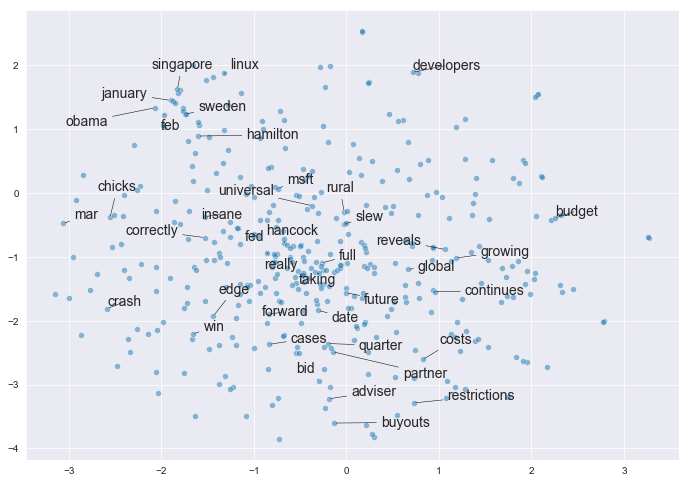

In [302]:
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Note that even though the text still overlaps some points, we no longer have overlapping text. Nifty! 

If you're interested in trying out `adjust_text` for your own plotting needs, you can find it [here](https://github.com/Phlya/adjustText). Be sure to import using the camelcase `adjustText`.

It's encouraging to see that even when the vector embeddings have been reduced to 2 dimensions, we see certain items clustering together. For example, we have **months** in the left/upper left, we have **corporate finance terms** near the bottom, and we have more **generic, non-topical words** (like 'full', 'really', 'slew') in the middle.

Note that if we were to run the t-SNE again with different parameters, we may observe some similarities to this result, but we're not guaranteed to see the exact same patterns. t-SNE, as compared to PCA, is not deterministic. Relatedly, tightness of clusters and distances between clusters are not always meaningful. It is meant primarily as an exploratory tool, rather than as a decisive indicator of similarity. 

# Averaging Word Embeddings 

We've gotten a sense of how word embeddings work as applied to this dataset. Now we can move on to some more interesting ML applications: finding titles that cluster together, and seeing what patterns emerge.

Instead of using Doc2Vec, which would require a lengthy training process, we can use a simpler [(and sometimes even more effective)](https://stackoverflow.com/questions/45234310/doc2vec-worse-than-mean-or-sum-of-word2vec-vectors) trick: averaging the embeddings of the word vectors in each document. In our case, a document refers to a title or a headline. 

In [283]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [284]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

37 docs removed
0 docs removed


In [286]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

Procedure and functions adapted from [this notebook](https://github.com/sdimi/average-word2vec/blob/master/notebook.ipynb) by Dimitris Spathis.

# t-SNE for Document Vectors

In [303]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

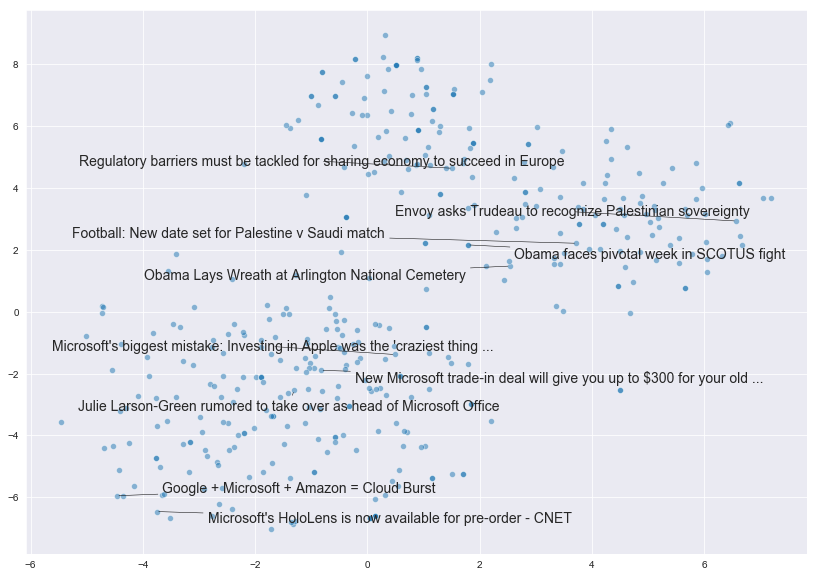

In [304]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Pretty interesting! We can see that the t-SNE has collapsed the document vectors into a dimensional space where the documents are spread out based on whether their content has more to do with countries, world leaders, and foreign affairs, or has more to do with technology companies. 

In [353]:
# Drop all the rows where the article popularities are unknown (this is only about 11% of the data)
main_data = main_data.drop(main_data[(main_data.Facebook == -1) | 
                                     (main_data.GooglePlus == -1) | 
                                     (main_data.LinkedIn == -1)].index)

# Also drop all rows where we don't know the source
main_data = main_data.drop(main_data[main_data['Source'].isna()].index)

main_data.shape

(81417, 11)

# Popularity Analysis

We still have 81,000 rows left to work with. 

Let's see if we can find any associations between sentiment and number of shares.

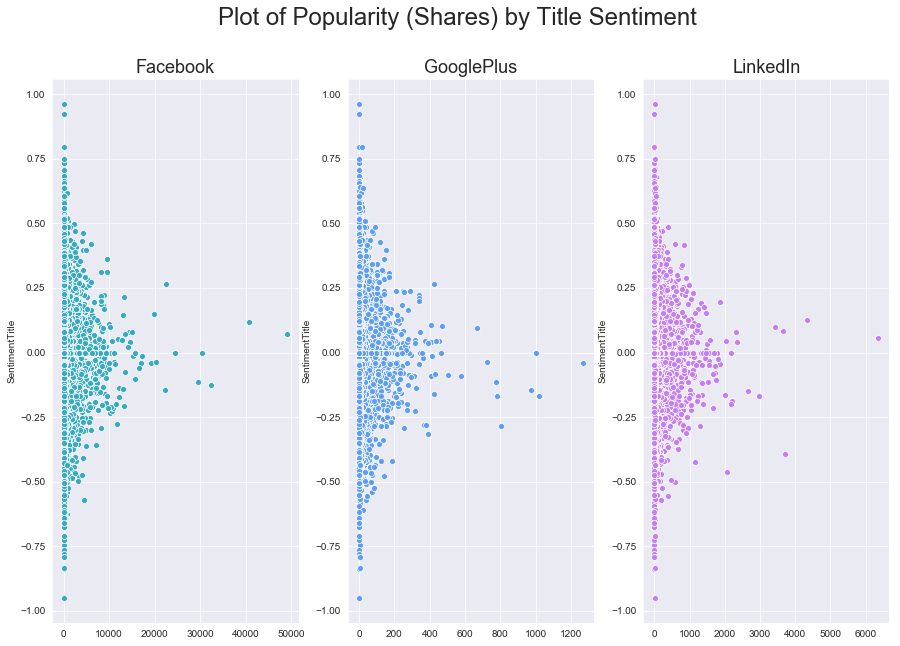

In [365]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

It's a bit hard to make out whether there's any relationship here, since a few articles are significant outliers in terms of their share counts. Let's try log-transforming the x-axis to see if we can reveal any patterns.

/Users/charlenechambliss/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


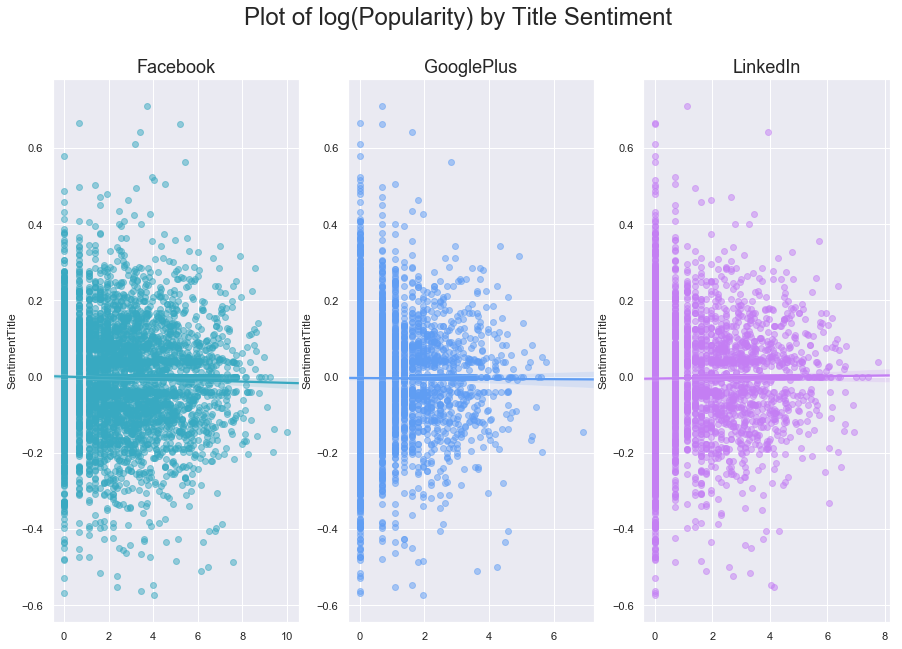

In [580]:
# Our data has over 80,000 rows, so let's subsample it to make the log-transformed scatterplot easier to read

subsample = main_data.sample(5000)

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]

for platform, subplot, color in zip(platforms, subplots, colors):
    # Regression plot, so we can gauge the linear relationship
    sns.regplot(x = np.log(subsample[platform] + 1), y = subsample['SentimentTitle'], 
                ax=subplot, 
                color=color,
                # Pass an alpha value to regplot's scatterplot call
                scatter_kws={'alpha':0.5})
    
    # Set a nice title, get rid of x labels
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of log(Popularity) by Title Sentiment', fontsize=24)

plt.show()

Contrary to what we might expect (from our idea of highly emotional, clickbaity headlines), in this dataset we find no relationship between headline sentiment and article popularity. 

In [448]:
import datetime

new_series = main_data['PublishDate'].map(pd.Timestamp.to_pydatetime)

t = datetime.datetime(1970, 1, 1)

(new_series - t).describe()

count                         81417
mean     16859 days 20:08:20.439011
std         64 days 18:03:50.779344
min             16747 days 05:25:00
25%             16805 days 20:54:00
50%             16857 days 06:04:23
75%             16913 days 08:15:00
max             16989 days 15:59:22
Name: PublishDate, dtype: object

So it looks like all of the articles were published within about a 200-day window.

In [449]:
max(new_series - t) - min(new_series - t)

Timedelta('242 days 10:34:22')

# Sentiment Analysis

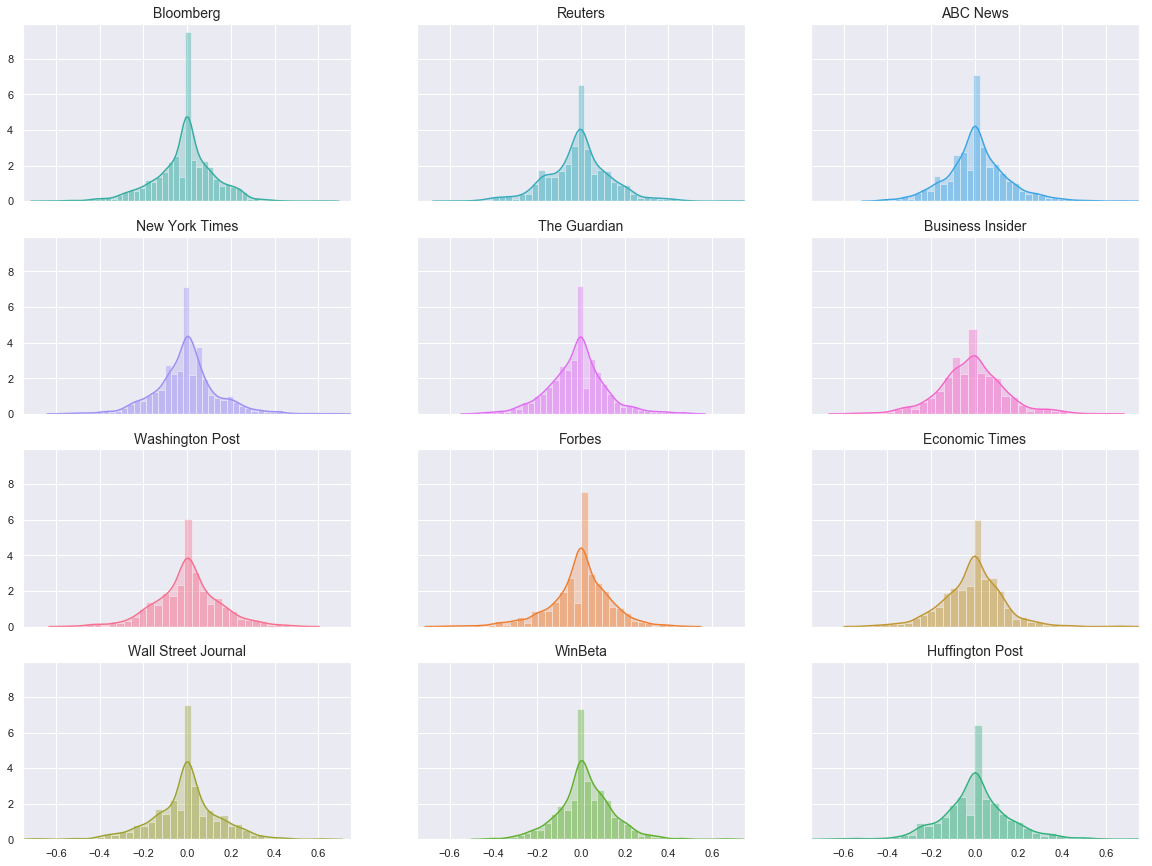

In [525]:
# Get the list of top 12 sources by number of articles
source_names = list(main_data['Source'].value_counts()[:12].index)
source_colors = list(sns.husl_palette(12, h=.5))

fig, ax = plt.subplots(4, 3, figsize=(20, 15), sharex=True, sharey=True)

ax = ax.flatten()
for ax, source, color in zip(ax, source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, color=color, kde_kws={'shade':True})
    ax.set_title(source, fontsize=14)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

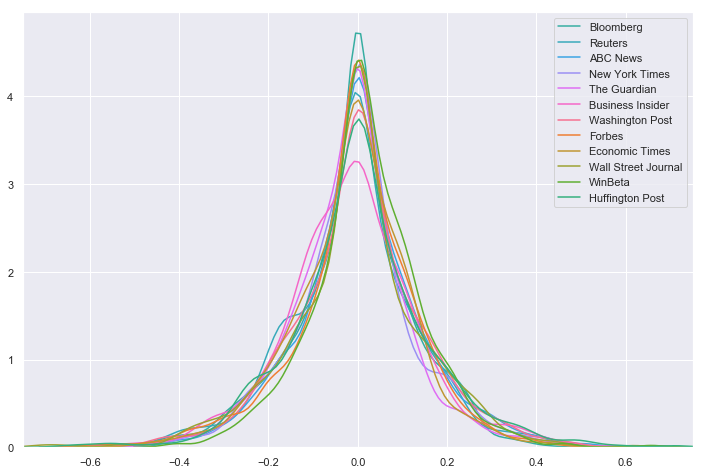

In [530]:
fig, ax = plt.subplots(figsize=(12, 8))

for source, color in zip(source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, hist=False, label=source, color=color)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

By overlaying the density estimates onto the same plot, we can get a better idea of how their shapes differ than trying to compare each plot to the other. 

We see that the sources' Sentiment distributions (for article titles) are very similar - it doesn't look like any one source is an outlier in terms of positive or negative headlines. Instead, all 12 of the most common sources have distributions centered around 0 with modestly sized tails.

In [494]:
main_data.loc[main_data['Source'] == 'Bloomberg']['SentimentTitle']

741     -0.079057
748     -0.236111
855      0.000000
861      0.108253
880      0.179167
915      0.000000
991     -0.041667
1008    -0.060459
1023    -0.041667
1082    -0.028646
1085     0.236228
1155     0.000000
1181    -0.041667
1201     0.059881
1210    -0.327894
1243    -0.125000
1314    -0.229167
1353    -0.188445
1372    -0.041667
1395    -0.020938
1419     0.000000
1420     0.062500
1454     0.011049
1469     0.000000
1526    -0.044194
1636     0.098272
1737     0.000000
1739     0.042049
1782     0.000000
1811     0.095339
           ...   
86028    0.044194
86206   -0.253472
86218   -0.252591
86293    0.118585
86299    0.188982
86305    0.072169
86350   -0.088388
86596   -0.116207
86886    0.000000
86983   -0.176777
87008   -0.041667
87025    0.034669
87141    0.118585
87204    0.063836
88140   -0.247978
88320   -0.042823
88335    0.000000
88400    0.047246
88419    0.207524
88483   -0.165851
88703   -0.088388
89832    0.000000
90013   -0.039528
90689   -0.176777
90733   -0

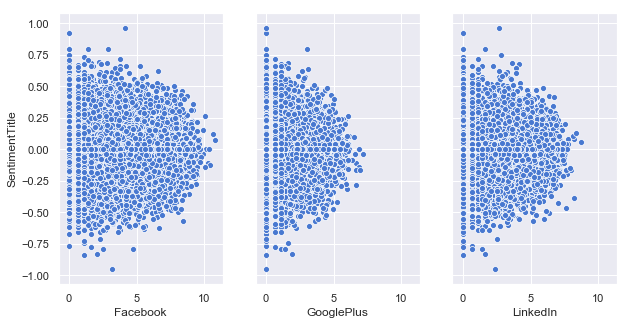

In [540]:
# try to visualize popularity by topic?

fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

subplots = [a for a in ax]
topics = list(main_data.Topic.value_counts().index)

for platform, subplot, topic in zip(platforms, subplots, topics):
    sns.scatterplot(x = np.log(main_data[platform] + 1), y = main_data['SentimentTitle'], 
                ax=subplot)#, color=topic)

In [582]:
main_data.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus',
       'LinkedIn'],
      dtype='object')

In [ ]:
"""
To be continued - next we'll be building a model to see if we can predict 
article popularity on each platform using the document vectors and a few other
features. I'll also be cleaning up the previous two sections.
"""